In [192]:
import sys
import os
import ruamel.yaml as yaml
sys.path.append(os.path.expanduser("~/Repositories/surrDAMH"))
from surrDAMH.modules import visualization_and_analysis as va
from surrDAMH.modules import analysis as ape
import matplotlib.pyplot as plt
import numpy as np

## Obligatory paths

In [193]:
path_to_local_folder = os.path.expanduser('~/charon_local')
filter_include = ["synth", "A04hm_H1", "nocond"]
filter_exclude = ["failed"]

conf_path = "config_mcmc_bayes.yaml"

# načtení dat a formatovani dat

In [194]:
from raw_data import MultiRawData
from raw_data import get_subfolder_paths_processed, filter_datasets

subfolders = get_subfolder_paths_processed(path_to_local_folder)
subfolders_filt = filter_datasets(subfolders, filter_include, filter_exclude)

all_raw_data = MultiRawData()
all_raw_data.load_from_folders_hdf5(subfolders_filt)

conf = yaml.safe_load(open(os.path.join(subfolders_filt[1], conf_path), 'r'))


## Filtrovaní dat

In [195]:
raw_data_filtered = all_raw_data.filter(types=[0, 2], tags=[1])
raw_data_filtered.print_statistics()

raw data: no_samples 167632
raw data: no_nonconverging 0
raw data: p (167632, 8)
raw data: w (167632, 1)
raw_data: np.sum(weights): 1950105.0
raw_data: all_sizes: {'types': (167632,), 'stages': (167632,), 'chains': (167632,), 'tags': (167632,), 'parameters': (167632, 8), 'observations': (167632, 26), 'parameters_normalized': (167632, 8), 'weights': (167632, 1), 'run_ids': (167632,)}


## Rekonstrukce modelu šumu pro výpočet likelihoodu

In [196]:
import surrDAMH.modules.Gaussian_process as gp

def compute_log_likelihood_all(data):
    # reconstruct covariance of the noise
    cov_mat = gp.assemble_covariance_matrix(conf['noise_model'])

    # rewritten likelihood for our model
    def get_log_likelihood_multivariate(observations, G_sample,noise_std):
        v = observations - G_sample.ravel()
        invCv = np.linalg.solve(noise_std,v)
        return -0.5*np.dot(v,invCv)

    # measurement from conf
    y_orig = np.array(conf['problem_parameters']['observations'])

    log_likelihood = np.zeros((data.shape[0],1))
    for idx,obs in enumerate(data):
        log_likelihood[idx] = get_log_likelihood_multivariate(obs,y_orig,cov_mat)
    
    return log_likelihood

## Vytvoření datasetu pro trénování a testování

In [218]:
data = raw_data_filtered.parameters_normalized
obs = raw_data_filtered.observations

obs_likelihood = compute_log_likelihood_all(obs)


In [210]:

# filter only data and obs with obs_likelihood > -30
data_filt = data[obs_likelihood.ravel() > -0.1, :]  # type: ignore
obs_filt = obs[obs_likelihood.ravel() > -0.1, :]  # type: ignore
obs_filt.shape

(1719, 26)

In [221]:
ref = data[np.argmax(obs_likelihood)]

In [304]:

for i in range(10000):
    ref = data[np.random.randint(0, data.shape[0])]
    tmp = np.linalg.norm(data - ref, axis=1)
    tmp1 = (tmp < 0.06) * (tmp > 1e-16)
    print(i)
    if np.sum(tmp1) > 1000:
        break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [305]:
obs[tmp1,3]

array([40.51540009, 45.67895303, 58.10724889, ..., 48.44536443,
       53.06285862, 52.19459667])

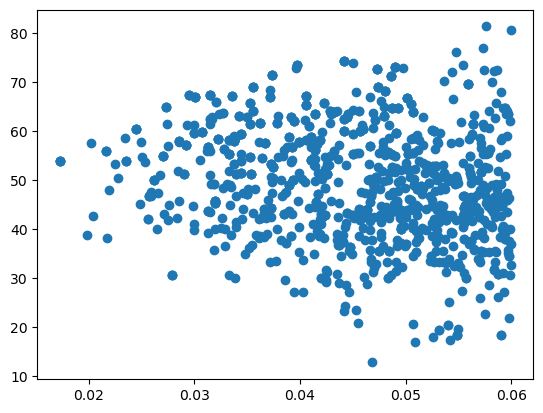

In [306]:
plt.scatter(np.linalg.norm(data[tmp1] - ref, axis=1), obs[tmp1,3])

In [307]:
data_filt = data[tmp1]
obs_filt = obs[tmp1]

In [308]:

from sklearn.model_selection import train_test_split

input_data = data_filt
output_data = obs_filt

# rozdělit data na trénovací a testovací set
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.1, random_state=42)

likelihood_train = compute_log_likelihood_all(y_train)
likelihood_test = compute_log_likelihood_all(y_test)
likelihood_train.shape

(972, 1)

In [309]:
## vytvoření datasetu pomocí class Snapshot pro surrogaty ze surrDAMH
from surrDAMH.modules.classes_SAMPLER import Snapshot
# create a list of snapshots
snapshots = []

for i in range(X_train.shape[0]):
    snapshots.append(Snapshot(X_train[i,:], y_train[i,:], weight=1.0))


# create a list of snapshots of likelihood only
snapshots_likelihood = []

for i in range(X_train.shape[0]):
    snapshots_likelihood.append(Snapshot(X_train[i,:], likelihood_train[i,:], weight=1.0))

k = X_train.shape[1]
m = y_train.shape[1]

In [310]:
# simulace acceptance probability

def acceptance_prob_all(prediction_likelihood):
    # create random permutation of filt_likelihood,acc_likelihood
    idx = np.random.permutation(len(prediction_likelihood))
    old_pred = prediction_likelihood[idx]
    old_test = likelihood_test[idx]

    alpha_s = np.minimum(likelihood_test + old_pred - prediction_likelihood - old_test,0)

    return np.exp(alpha_s)

In [311]:
def plot_results_only_likelihood(res_surr):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # First subplot
    axs[0].scatter(likelihood_test, res_surr, alpha=0.1, marker='.')
    axs[0].plot([-10,0],[-10,0], color='red')
    axs[0].set_ylim(-10, 0)
    axs[0].set_xlim(-10, 0)

    # Second subplot
    alpha_all = acceptance_prob_all(res_surr)
    axs[1].hist(alpha_all)
    mean_acceptance = np.mean(alpha_all)
    axs[1].set_title(f'mean acceptance = {mean_acceptance}')
    plt.show()


def plot_results_all(res_surr):
    plot_results_only_likelihood(compute_log_likelihood_all(res_surr))

# Polynomialni model

SURROGATE polynomial degree increased to: 1 - no poly: 9


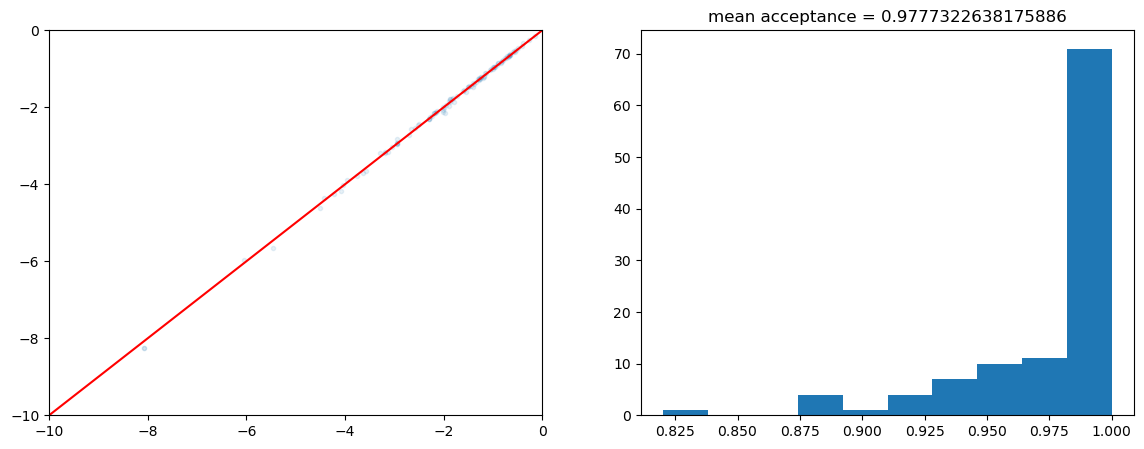

In [328]:
import surrDAMH.modules.surrogate_poly as surrogate_poly

surr_obj = surrogate_poly.Surrogate_update(k,m,max_degree=1)
surr_obj.add_data(snapshots)
SOL = surr_obj.update()
surr_apply_obj = surrogate_poly.Surrogate_apply(k,m)
res_surr = surr_apply_obj.apply(SOL[0], X_test)

# compute alphas and plot results
plot_results_all(res_surr)

In [334]:
SOL[0][0][:,2]


array([ 5.86898201e+01,  4.32104069e+02,  4.39510866e+02, -5.91778728e+02,
        1.29270415e+02,  1.31602124e+01,  1.43957081e+00,  5.56779836e-01,
       -7.37079606e-01])

SURROGATE polynomial degree increased to: 1 - no poly: 9
SURROGATE polynomial degree increased to: 5 - no poly: 1287


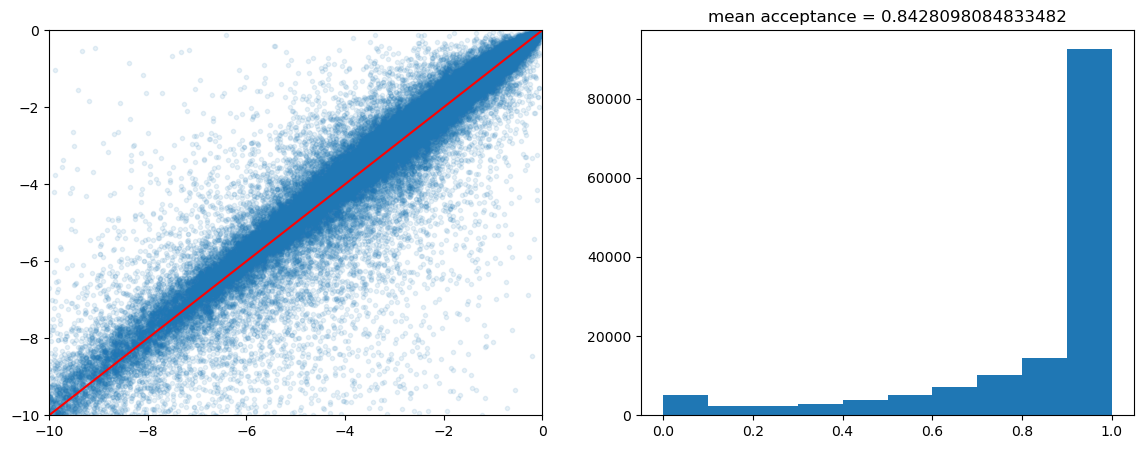

In [147]:
surr_obj = surrogate_poly.Surrogate_update(k,m,max_degree=5)
surr_obj.add_data(snapshots)
SOL = surr_obj.update()
surr_apply_obj = surrogate_poly.Surrogate_apply(k,m)
res_surr = surr_apply_obj.apply(SOL[0], X_test)


# compute alphas and plot results
plot_results_all(res_surr)

#### Zkouška aproximace pouze log-likelihoodu

SURROGATE polynomial degree increased to: 1 - no poly: 9
SURROGATE polynomial degree increased to: 5 - no poly: 1287


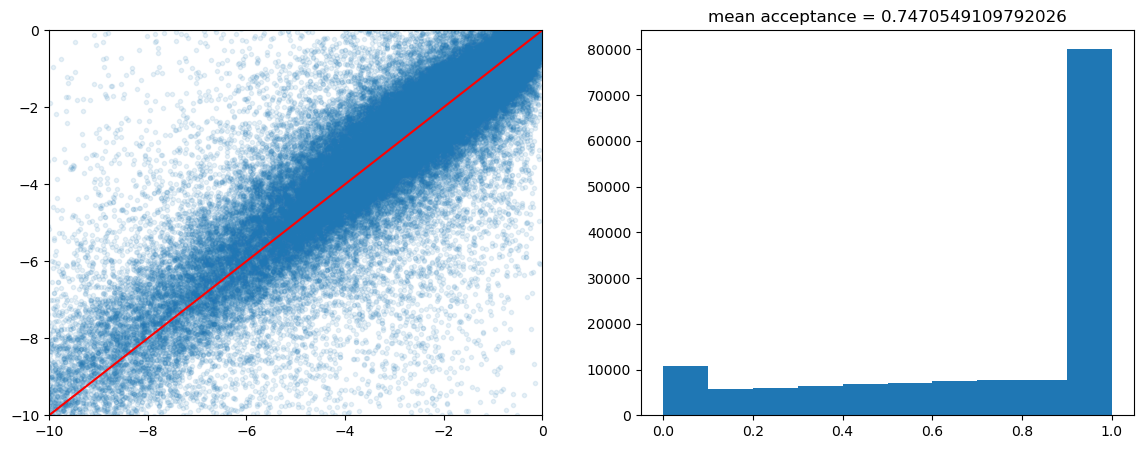

In [148]:
surr_obj = surrogate_poly.Surrogate_update(k,1,max_degree=5)
surr_obj.add_data(snapshots_likelihood)
SOL = surr_obj.update()
surr_apply_obj = surrogate_poly.Surrogate_apply(k,1)
res_surr = surr_apply_obj.apply(SOL[0], X_test)


# compute alphas and plot results
plot_results_only_likelihood(res_surr)

## Polynomial model from sklearn

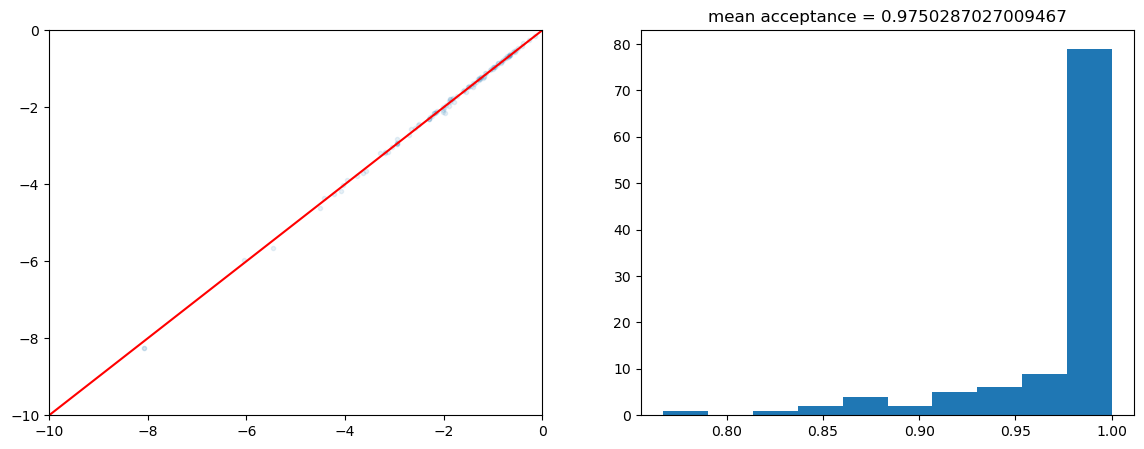

In [312]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def polynomial_regression(X, y, degree):
    # Create a pipeline that first creates polynomial features and then fits a linear regression model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X, y)
    return model

tmp = polynomial_regression(X_train, y_train,1)
res_surr = tmp.predict(X_test)

# compute alphas and plot results
plot_results_all(res_surr)


In [326]:
import numpy as np


def jacobian(x, model):
    # x is the point where you want to evaluate the Jacobian
    # model is the fitted polynomial regression model
    degree = model.named_steps['polynomialfeatures'].degree
    coeffs = model.named_steps['linearregression'].coef_[0]  # Note the [0] to select the correct coefficients
    jacobian_matrix = np.zeros(len(x))

    # Loop over each feature
    for i in range(len(x)):
        # Linear term
        jacobian_matrix[i] += coeffs[i + 1]

        # Quadratic terms
        for j in range(i):
            if i == j:
                jacobian_matrix[i] += 2 * coeffs[len(x) + j] * x[i]
            else:
                jacobian_matrix[i] += coeffs[len(x) + j] * x[j]

    return jacobian_matrix



In [327]:
J = jacobian(X_test[0], tmp)

IndexError: index 9 is out of bounds for axis 0 with size 9

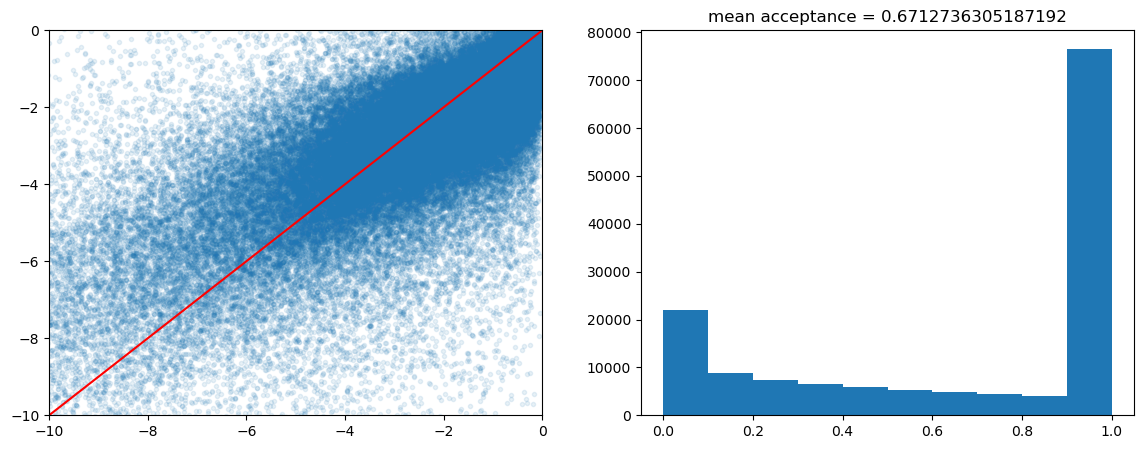

In [153]:
tmp = polynomial_regression(X_train, likelihood_train,3)
res_surr = tmp.predict(X_test)

# compute alphas and plot results
plot_results_only_likelihood(res_surr)


# RBF model

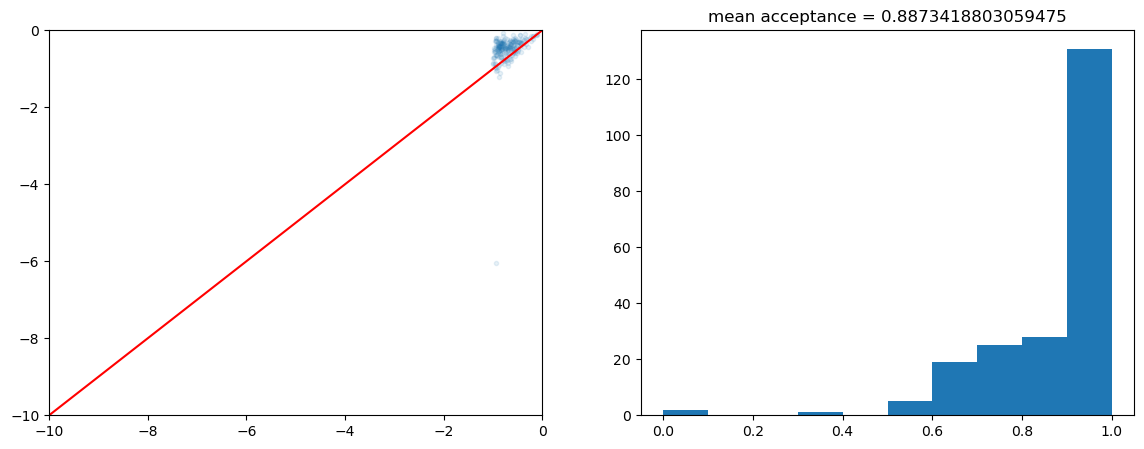

In [67]:
from surrDAMH.modules import surrogate_rbf
surr_obj = surrogate_rbf.Surrogate_update(no_parameters=k, no_observations=m, 
                                          initial_iteration=None, no_keep=None, expensive=False, 
                                          kernel_type=0, solver_tol_exp=-6, solver_type='minres')
surr_obj.add_data(snapshots)
SOL = surr_obj.update()
surr_apply_obj = surrogate_rbf.Surrogate_apply(k,m,kernel_type=0)
res_surr = surr_apply_obj.apply(SOL[0], X_test)

# compute alphas and plot results
plot_results_all(res_surr)

### test only approximate log-likelihood

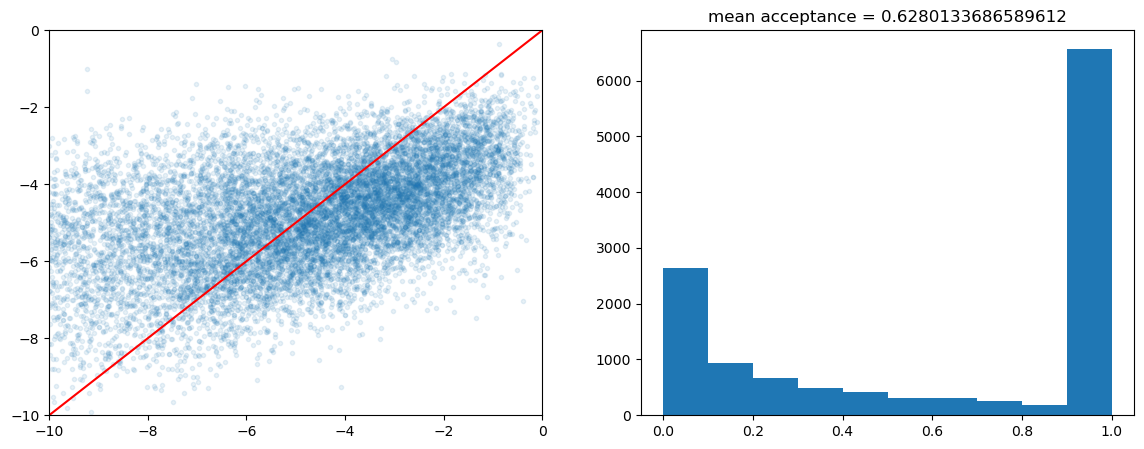

In [94]:
surr_obj = surrogate_rbf.Surrogate_update(no_parameters=k, no_observations=1, 
                                          initial_iteration=None, no_keep=None, expensive=False, 
                                          kernel_type=0, solver_tol_exp=-6, solver_type='minres')
surr_obj.add_data(snapshots_likelihood)
SOL = surr_obj.update()
surr_apply_obj = surrogate_rbf.Surrogate_apply(k,1,kernel_type=0)
res_surr = surr_apply_obj.apply(SOL[0], X_test)

# compute alphas and plot results
plot_results_only_likelihood(res_surr)

## RBF pomocí scipy

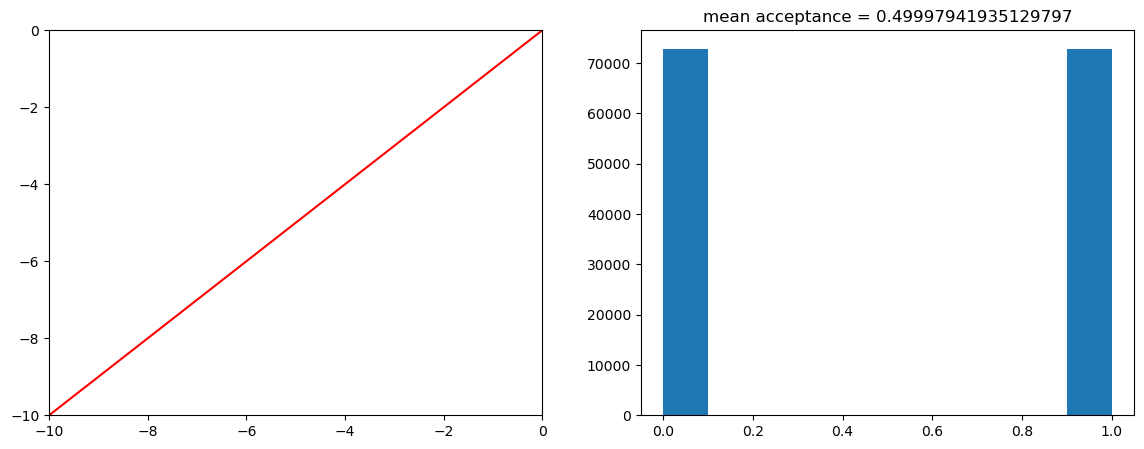

In [154]:
from scipy.interpolate import RBFInterpolator

# Použití funkce surrogate_model
"""    kernel: typ jaderné funkce ('linear', 'thin_plate_spline', 'cubic', 'quintic', 'multiquadric', 
             'inverse_multiquadric', 'inverse_quadratic', 'gaussian')"""
tmp = RBFInterpolator(X_train, y_train, kernel='linear')
res_surr = tmp(X_test)


# compute alphas and plot results
plot_results_all(res_surr)

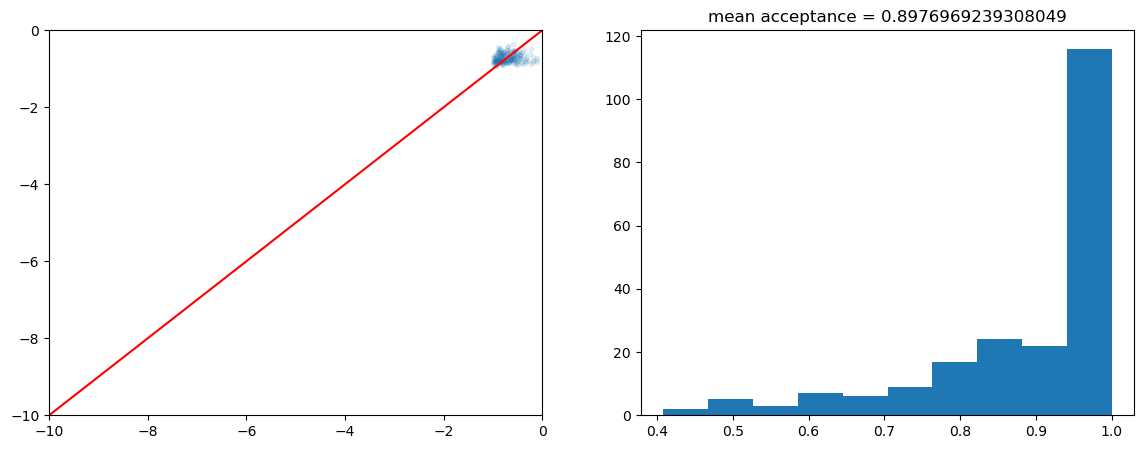

In [69]:
# aproximace pouze likelihood
tmp = RBFInterpolator(X_train, likelihood_train, kernel='linear')
res_surr = tmp(X_test)


# compute alphas and plot results
plot_results_only_likelihood(res_surr)

## více typů RBF v scipy
obdobná implementace, ale scipy je rychlejší

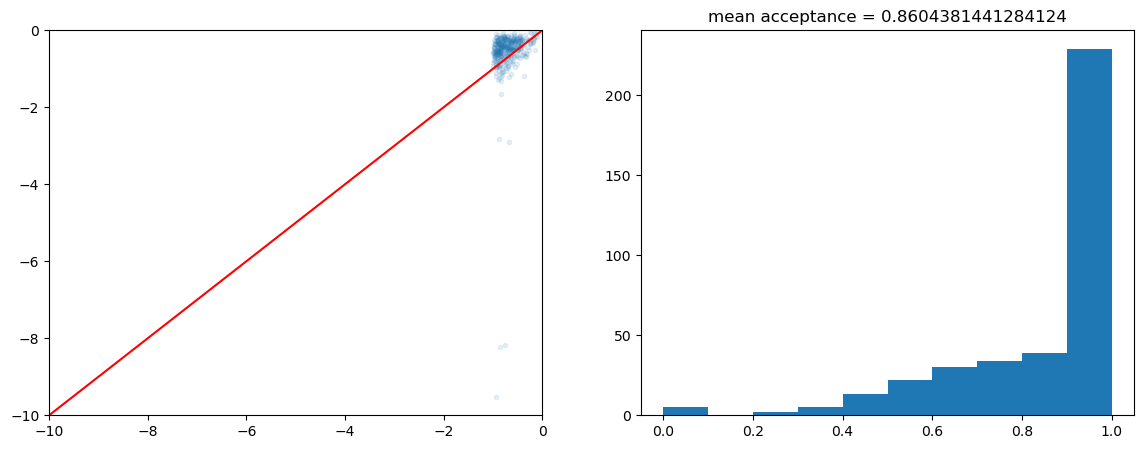

In [87]:
# Použití funkce surrogate_model
"""    kernel: typ jaderné funkce ('linear', 'thin_plate_spline', 'cubic', 'quintic', 'multiquadric', 
             'inverse_multiquadric', 'inverse_quadratic', 'gaussian')"""

tmp = RBFInterpolator(X_train, y_train, kernel='linear',degree=1, epsilon=1)
res_surr = tmp(X_test)


# compute alphas and plot results
plot_results_all(res_surr)

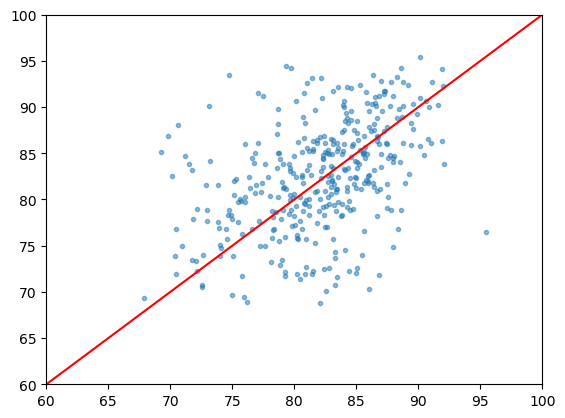

In [88]:

i = 24

plt.scatter(res_surr[:,i], y_test[:,i], alpha=0.5, marker='.')
plt.plot([60,100],[60,100], color='red')
plt.ylim(60,100)
plt.xlim(60,100)
plt.show()

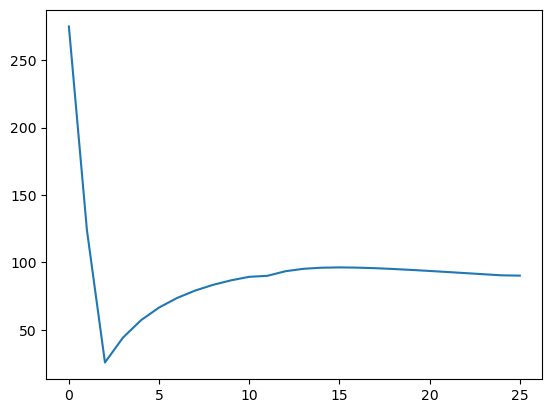

In [48]:
plt.plot(res_surr[136,0:26])

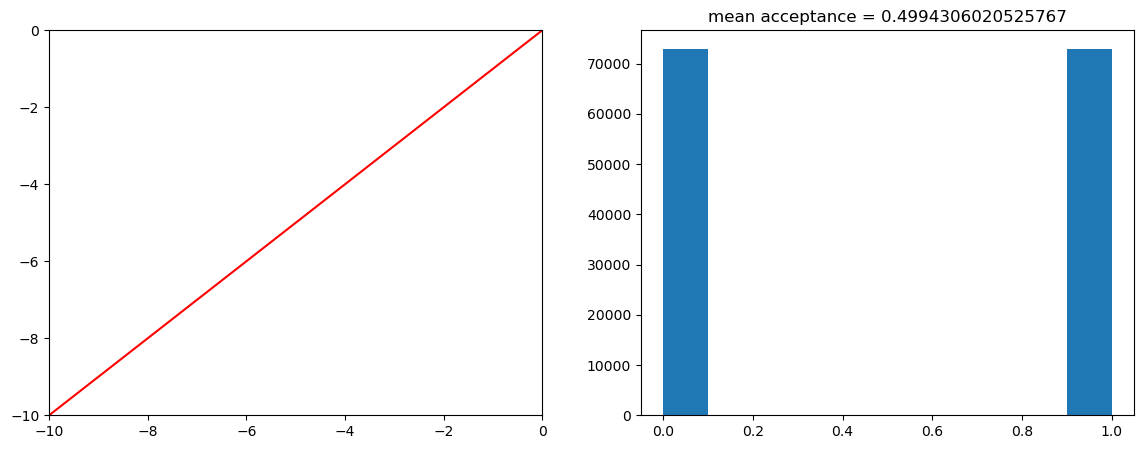

In [155]:
# Použití funkce surrogate_model
"""    kernel: typ jaderné funkce ('linear', 'thin_plate_spline', 'cubic', 'quintic', 'multiquadric', 
             'inverse_multiquadric', 'inverse_quadratic', 'gaussian')"""

tmp = RBFInterpolator(X_train, y_train, kernel='thin_plate_spline',degree=4, epsilon=1)
res_surr = tmp(X_test)


# compute alphas and plot results
plot_results_all(res_surr)

# Zkouška pomocí neural network v sklearn

Iteration 1, loss = 4451.11198569
Iteration 2, loss = 4003.52327578
Iteration 3, loss = 3064.91934306
Iteration 4, loss = 2084.83474489
Iteration 5, loss = 1397.04174795
Iteration 6, loss = 999.18459688
Iteration 7, loss = 774.43794016
Iteration 8, loss = 627.86282745
Iteration 9, loss = 516.68298741
Iteration 10, loss = 426.97582459
Iteration 11, loss = 354.44011361
Iteration 12, loss = 297.04418375
Iteration 13, loss = 252.99160563
Iteration 14, loss = 220.41947353
Iteration 15, loss = 197.25282932
Iteration 16, loss = 181.17067557
Iteration 17, loss = 170.21243817
Iteration 18, loss = 162.77853730
Iteration 19, loss = 157.54207000
Iteration 20, loss = 153.73142097
Iteration 21, loss = 150.78983103
Iteration 22, loss = 148.40737262
Iteration 23, loss = 146.41313390
Iteration 24, loss = 144.65389827
Iteration 25, loss = 143.10083297
Iteration 26, loss = 141.61139684
Iteration 27, loss = 140.24391008
Iteration 28, loss = 138.95363791
Iteration 29, loss = 137.69174006
Iteration 30, loss

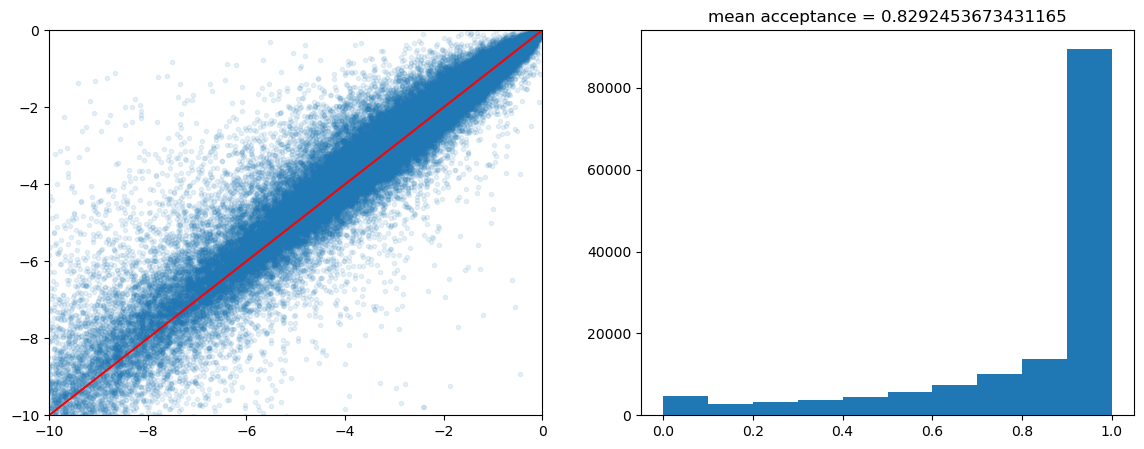

In [156]:
from sklearn.neural_network import MLPRegressor

# vytvořit instanci MLPRegressoru
mlp = MLPRegressor(hidden_layer_sizes=(200,),activation='relu', solver='adam', max_iter=50000, verbose=True)

# trénovat model
mlp.fit(X_train, y_train)


res_surr = mlp.predict(X_test)

# compute alphas and plot results
plot_results_all(res_surr)

Iteration 1, loss = 2929.35061793
Iteration 2, loss = 1137.47156557
Iteration 3, loss = 656.54708690
Iteration 4, loss = 451.00561380
Iteration 5, loss = 329.27871474
Iteration 6, loss = 252.65241284
Iteration 7, loss = 205.52762754
Iteration 8, loss = 177.87900859
Iteration 9, loss = 162.48286366
Iteration 10, loss = 154.44236652
Iteration 11, loss = 150.47946390
Iteration 12, loss = 148.65509450
Iteration 13, loss = 147.83607331
Iteration 14, loss = 147.51016470
Iteration 15, loss = 147.37980486
Iteration 16, loss = 147.32294166
Iteration 17, loss = 147.29173392
Iteration 18, loss = 147.26371169
Iteration 19, loss = 147.20953691
Iteration 20, loss = 147.08686966
Iteration 21, loss = 147.06625669
Iteration 22, loss = 146.86371719
Iteration 23, loss = 146.58727590
Iteration 24, loss = 145.52806299
Iteration 25, loss = 140.45929971
Iteration 26, loss = 127.69209371
Iteration 27, loss = 110.55781218
Iteration 28, loss = 97.72720654
Iteration 29, loss = 89.90478681
Iteration 30, loss = 84

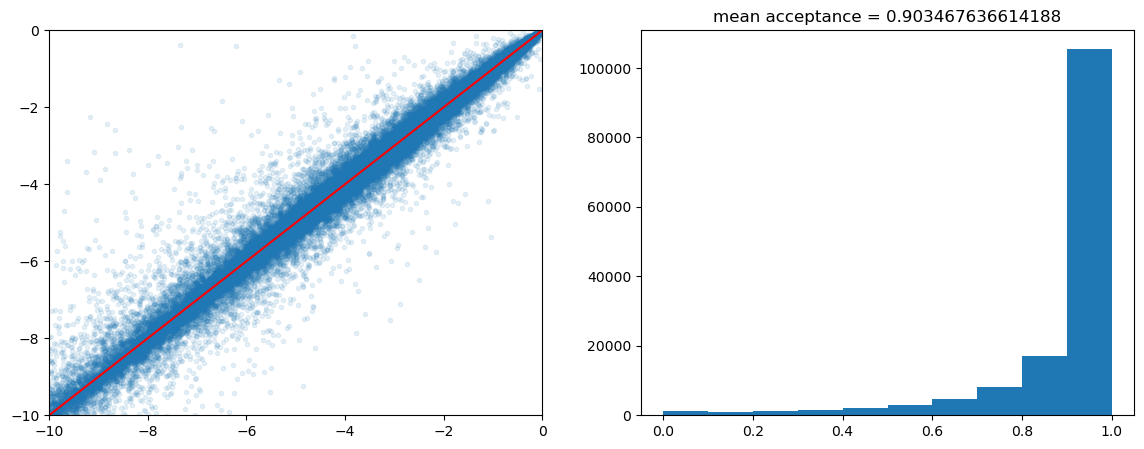

In [158]:
# vytvořit instanci MLPRegressoru
mlp = MLPRegressor(hidden_layer_sizes=(500,500),activation='tanh', solver='adam', max_iter=50000, verbose=True)

# trénovat model
mlp.fit(X_train, y_train)


res_surr = mlp.predict(X_test)

# compute alphas and plot results
plot_results_all(res_surr)

Iteration 1, loss = 10.97587954
Iteration 2, loss = 8.36310949
Iteration 3, loss = 6.34846209
Iteration 4, loss = 4.89266452
Iteration 5, loss = 3.96671726
Iteration 6, loss = 3.40939137
Iteration 7, loss = 3.09718654
Iteration 8, loss = 2.91927756
Iteration 9, loss = 2.82158113
Iteration 10, loss = 2.76145407
Iteration 11, loss = 2.72022596
Iteration 12, loss = 2.68894517
Iteration 13, loss = 2.66117446
Iteration 14, loss = 2.63717982
Iteration 15, loss = 2.61638436
Iteration 16, loss = 2.59668983
Iteration 17, loss = 2.58051480
Iteration 18, loss = 2.56598238
Iteration 19, loss = 2.55308453
Iteration 20, loss = 2.54175464
Iteration 21, loss = 2.53277905
Iteration 22, loss = 2.52421369
Iteration 23, loss = 2.51778731
Iteration 24, loss = 2.51180700
Iteration 25, loss = 2.50673186
Iteration 26, loss = 2.50292293
Iteration 27, loss = 2.49975770
Iteration 28, loss = 2.49691643
Iteration 29, loss = 2.49466136
Iteration 30, loss = 2.49278977
Iteration 31, loss = 2.49111126
Iteration 32, lo

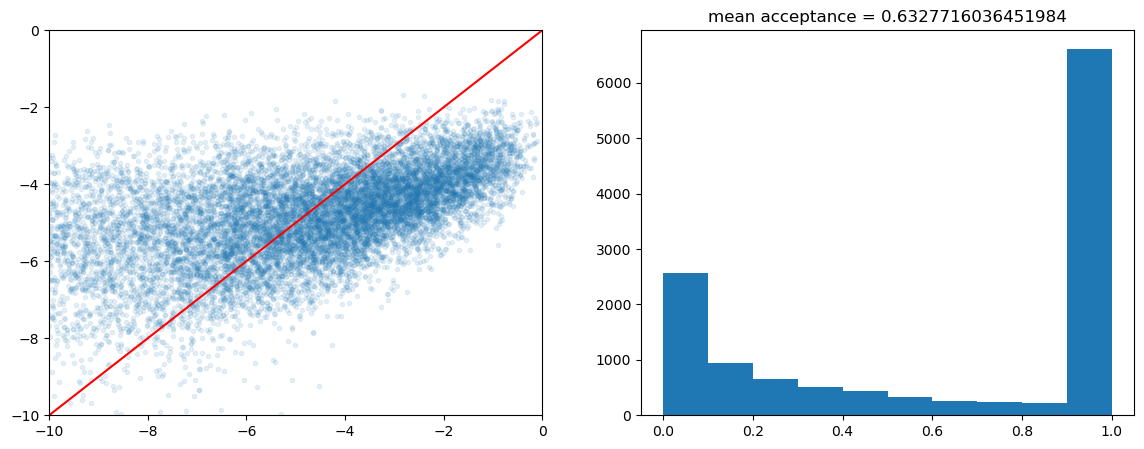

In [37]:
# vytvořit instanci MLPRegressoru
mlp = MLPRegressor(hidden_layer_sizes=(100,),activation='tanh', solver='adam', max_iter=5000, verbose=True)

# trénovat model
mlp.fit(X_train, likelihood_train.ravel())


res_surr = mlp.predict(X_test)

# compute alphas and plot results
plot_results_only_likelihood(res_surr.reshape(-1,1))

# pytorch


In [ ]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Creating a simple neural network in PyTorch


class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x



# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Create DataLoader for the training set
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Create the model
model = Net(X_train.shape[1], y_train.shape[1])

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
lr = 0.1
# Train the model
for i in range(200):
    lr = lr * 0.9  # type: ignore
    print("Learning rate is now:", lr)  # type: ignore
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    num_epochs = 100
    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            # forward
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item()))  # type: ignore


# Test the model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

# Convert tensor to numpy array
res_surr = y_pred_tensor.numpy()

# Compute alphas and plot results
plot_results_all(res_surr)


In [189]:
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.5, random_state=42)
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
likelihood_train = compute_log_likelihood_all(y_train)
likelihood_test = compute_log_likelihood_all(y_test)
likelihood_train.shape


(80982, 1)

In [191]:
# Create DataLoader for the training set
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)  # Adjust the batch size

# Create the model
# model = Net(X_train.shape[1], y_train.shape[1])

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Decrease the learning rate

# Add a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

# Train the model
num_epochs = 50000
best_loss = np.inf
patience, trials = 100, 0

for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        # forward
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Adjust the learning rate based on the loss
    scheduler.step(loss)


    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item()))

    # Early stopping
    if loss.item() < best_loss:
        best_loss = loss.item()
        trials = 0
    else:
        trials += 1
        if trials >= patience:
            print(f'Stopping early at epoch {epoch+1}')
            break

# Test the model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

# Convert tensor to numpy array
res_surr = y_pred_tensor.numpy()


Epoch [1/50000], Loss: 6.5707
Epoch [2/50000], Loss: 5.0992
Epoch [3/50000], Loss: 6.3085
Epoch [4/50000], Loss: 6.8872
Epoch [5/50000], Loss: 18.4465
Epoch [6/50000], Loss: 7.0092
Epoch [7/50000], Loss: 10.0033
Epoch [8/50000], Loss: 5.4184
Epoch [9/50000], Loss: 4.6817
Epoch [10/50000], Loss: 8.3787
Epoch [11/50000], Loss: 5.4895
Epoch [12/50000], Loss: 7.4783
Epoch [13/50000], Loss: 8.3723
Epoch [14/50000], Loss: 9.8610
Epoch [15/50000], Loss: 5.6908
Epoch [16/50000], Loss: 5.9652
Epoch [17/50000], Loss: 12.4389
Epoch [18/50000], Loss: 3.7238
Epoch [19/50000], Loss: 5.6552
Epoch [20/50000], Loss: 5.5847
Epoch [21/50000], Loss: 5.3771
Epoch [22/50000], Loss: 7.9710
Epoch [23/50000], Loss: 6.9975
Epoch [24/50000], Loss: 15.4081
Epoch [25/50000], Loss: 10.3205
Epoch [26/50000], Loss: 10.0686
Epoch [27/50000], Loss: 7.9511
Epoch [28/50000], Loss: 3.8865
Epoch [29/50000], Loss: 9.0758
Epoch [30/50000], Loss: 5.8773
Epoch [31/50000], Loss: 3.5307
Epoch [32/50000], Loss: 5.1168
Epoch [33/5

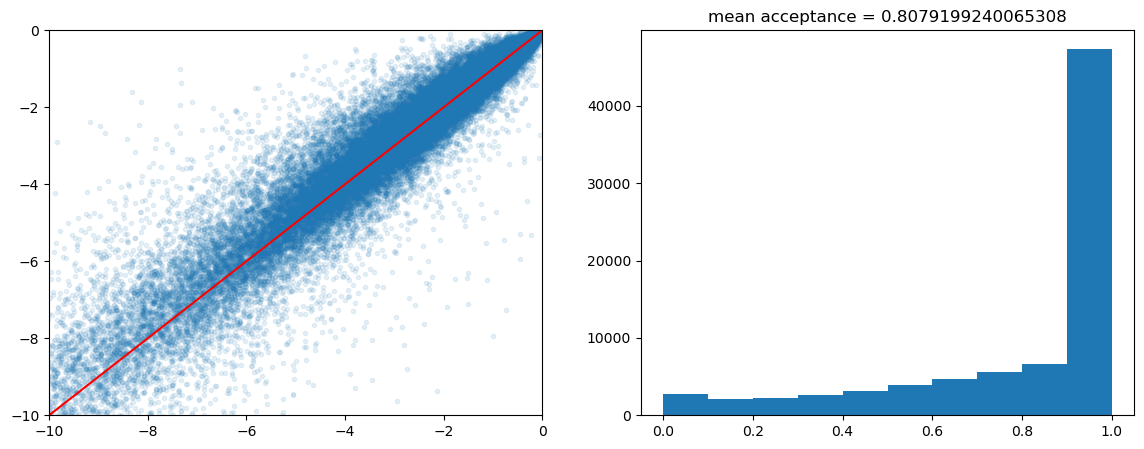

In [190]:

# Compute alphas and plot results
plot_results_all(res_surr)
